# Simpson characters detection - Keras CNN - Acc 97% 
### **Yassine Ghouzam, PhD**
#### 24/07/2017

<pre>Simpson characters detection, detects simpson characters using a deep learning approach.
Copyright (C) 2017  GHOUZAM YASSINE

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see http://www.gnu.org/licenses/.</pre>


* **1. Introduction**


* **2. Data preparation**
    * 2.1 Load and prepare the data
    * 2.2 Normalization
    * 2.3 Label encoding
 
    
* **3. Convolutional Neural Network**
    * 3.1 Define the model
    * 3.2 Set the optimizer and annealer
    * 3.3 Data augmentation and fitting
   
    
* **4. Evaluate the model**
    * 4.1 Confusion matrix
    * 4.2 Some examples
    
   
* **5. Using CNN dynamically**
    * 5.1 Video demo

# 1. Introduction

I am a Simpsons fan and i watch a lot of Simpson episodes. The Simpson characters are so simple and unconventional which make them incredible. I wanted to build a neural network which can recognize simpsons characters. The model a built is very accurate (97%) and can be used to establish occurence statistics on The Simpson episodes. 

So this is a personal project i'hve done. The aim is to detect the simpson character individually from pictures, then from a video using Deep Learning.

I used a Convolutional Neural Network trained on only 20k images (around 1k images per character). The model learned 20 simpson characters.The popular ones (homer, bart, lisa ...) were learned with more than 1k images while infrequent characters were learned with only 400 images.

I choosed to build the model with the Keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (Simpson characters images) then i'll focus on the CNN modeling and evaluation. Finally, i'll do a quick demo of the predictive model with a video. 

I achieved 97.77% of accuracy with this CNN trained in 15h on a single CPU (I5 2500k). With a >= 3.0 GPU capabilites (GTX 650 - Recent GPUs) you can use tensorflow-gpu with keras. Computation will be much much faster !!!

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The video demonstration

<img src="Simpsons_cast.png"></img>

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import scipy
import cv2
%matplotlib inline

np.random.seed(2)

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json

import warnings

warnings.filterwarnings('ignore')

Using TensorFlow backend.


# 2. Data preparation
## 2.1 Load and prepare the data

For this project i used the Simpson character data available in kaggle : https://www.kaggle.com/alexattia/the-simpsons-characters-dataset.

This dataset is composed of 20 folders for the training process (one for each character) with 400-2000 pictures in each folder. It includes also a train folder with 990 images labeled.

So firslty ill define two functions load_train_set and load_test_set which load, resize and prepare the images from the train set and test set, respectively.

- Each picture is resized in a 64x64 pixels format with the lanczos algorithm for resampling.

In [2]:
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}

In [3]:
# Load the data
def load_train_set(dirname,dict_characters):
    X_train = []
    Y_train = []
    for label,character in dict_characters.items():
        list_images = os.listdir(dirname+'/'+character)
        for image_name in list_images:
            image = scipy.misc.imread(dirname+'/'+character+'/'+image_name)
            X_train.append(scipy.misc.imresize(image,(64,64),interp='lanczos'))
            Y_train.append(label)
    return np.array(X_train), np.array(Y_train)


# load the test data

def load_test_set(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = scipy.misc.imread(dirname+'/'+image_name)
        X_test.append(scipy.misc.imresize(image,(64,64),interp='lanczos'))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)

X_train, Y_train = load_train_set("I:/yassine/Documents/MOOC/test/Simpson/simpsons_dataset", dict_characters)       
X_test, Y_test = load_test_set("I:/yassine/Documents/MOOC/test/Simpson/kaggle_simpson_testset", dict_characters) 

## 2.2 Normalization

In [4]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

Once the data loaded. I perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN convergs faster on [0..1] data than on [0..255] data.

I simply divide the RGB values by 255 which is the maximum RGV value.

Let's see some samples.
But before ill define two usefull functions, one that randomly displays 20 images with their observed labels 
and their predicted ones (if all arguments are provided). The other function randomly picks up one element per type in an array. This last function will be used to choose one of each simpson characters to display.

In [5]:
def display_samples(samples_index,imgs,obs, preds_classes=None,preds=None):
    """This function randomly displays 20 images with their observed labels 
    and their predicted ones(if preds_classes and preds are provided)"""
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_index[n]
            ax[row,col].imshow(imgs[index])
            
            actual_label = dict_characters[obs[index]].split("_")[0]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("fantasy")
            
            ax[row,col].text(1, 54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            
            if preds_classes != None and preds != None:
                predicted_label = dict_characters[preds_classes[index]].split('_')[0]
                predicted_proba = max(preds[index])*100
                predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
                ax[row,col].text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            n += 1

In [6]:
def pick_up_random_element(elem_type,array):
    """This function randomly picks up one element per type in the array"""
    return int(random.choice(np.argwhere(array == elem_type)))

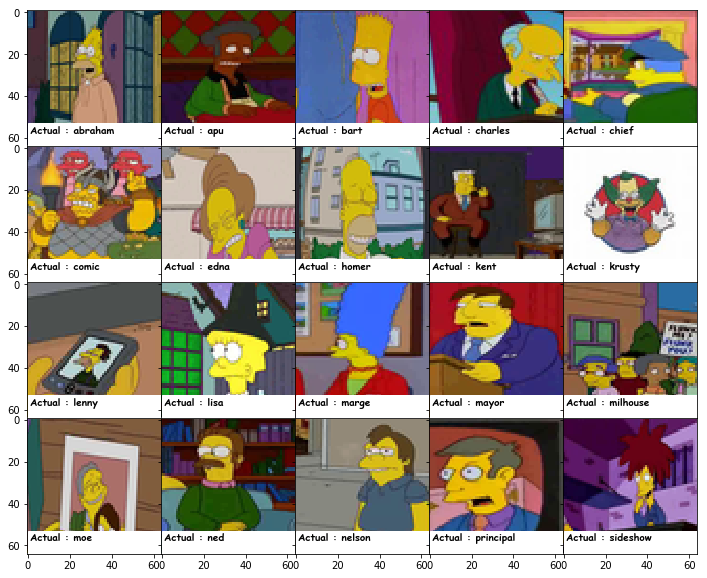

In [7]:
samples = [pick_up_random_element(elem_type,Y_train) for elem_type in range(20)]

display_samples(samples,X_train,Y_train)

So you can see that the pictures are direclty taken from the simpson episodes. So the model have to deal with disguised or partially hidden characters. That will make our model robust for the generalization.

## 2.3 Label encoding

In [8]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 20)
Y_test = to_categorical(Y_test, num_classes = 20)

Labels are 20 characters numbers from 0 to 19. We need to encode these labels to one hot vectors (ex : "bart_simpson"  -> 2 -> [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).

# 3. Convolutional Neural Network
## 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers then 64 filters and 86 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the N neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

Batch Normalization is a technical trick to make training faster. Such as we did with the normalization step as a pre-processing step to make the data comparable across features, the batch normalization will normalize the weights and parameters to avoid the data being too big or too small again ("internal covariate shift"). By normalizing the data in each mini-batch, this problem is largely avoided.


The Flatten layer is use to convert the feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(20,activation="softmax")) the net outputs distribution of probability of each class.


In [9]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(1024, activation = "relu"))
#model.add(Dropout(0.5))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation = "softmax"))


## 3.2 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

The most important function is the optimizer. It the function that will iteratively improves parameters (filters kernel values, weights and bias of neurons ...) and minimise the loss. 

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.
We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is a slower than RMSprop.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The metric function "accuracy" is used is to evaluate the performance our model.
This metric function is similar to the loss function, except that the results from evaluating a metric are not used when training the model (only for evaluation).

In [10]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, decay=1e-6)

Since i have already trained the model during 15 hours, the optimal weights have already been computed and i'll use them to load the model. 

In [11]:
PRETRAINED = True

if PRETRAINED :
    json_file = open('I:/yassine/Documents/MOOC/test/Simpson/best_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("I:/yassine/Documents/MOOC/test/Simpson/best_model.hdf5")

In [12]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Set a learning_rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

<img src="http://img1.imagilive.com/0717/learningrates.jpg"> </img>

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i choosed to use an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if is necessary (accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.


In [14]:
save_best = ModelCheckpoint("I:/yassine/Documents/MOOC/test/Simpson/best_model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

## 3.3 Data augmentation and fitting

In order to avoid overfitting problem we need to expand artificially our dataset. you can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variation occuring during a simpson movie for example.

For example, when the character is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, you can easily double or triple the number of training examples and create a very robust model.

The difference is important : 
   - without data augmentation i obtained an accuracy of 93.5%
   - With data augmentation i achieved 97.77% of accuracy
   
In this notebook this step has been already done before so it is automatically by-passed.

In [15]:
if PRETRAINED == False:
    
    epochs = 60 
    batch_size = 32
    
    
    # With data augmentation to prevent the overfitting (accuracy 0.97)
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    
    datagen.fit(X_train)
    
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size, shuffle=True),
                              epochs = epochs, validation_data = (X_test,Y_test),
                               steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, save_best])
    
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    
    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    
    
    # serialize model to JSON
    model_json = model.to_json()
    with open("I:/yassine/Documents/MOOC/test/Simpson/best_model.json", "w") as json_file:
        json_file.write(model_json)
        # serialize weights to HDF5
        #model.save_weights("model_big.h5")

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   - Randomly flips images horizontally
   

Once our model is ready, we fit the training dataset .

# 4. Evaluate the model
## 4.1 Confusion matrix 

In [16]:
# predict results
loss, acc = model.evaluate(X_test,Y_test,verbose = 0)

print("Simpson characters were predicted with a loss of {:.5f} and an accuracy of {:.2f}%".format(loss,acc*100))

Simpson characters were predicted with a loss of 0.09837 and an accuracy of 97.78%


The model reaches almost 98% (97.7+%) accuracy on the validation dataset after 60 epochs. 

Our model is very well trained !!! 


Let's look at the confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.
I plot the confusion matrix of the validation results.

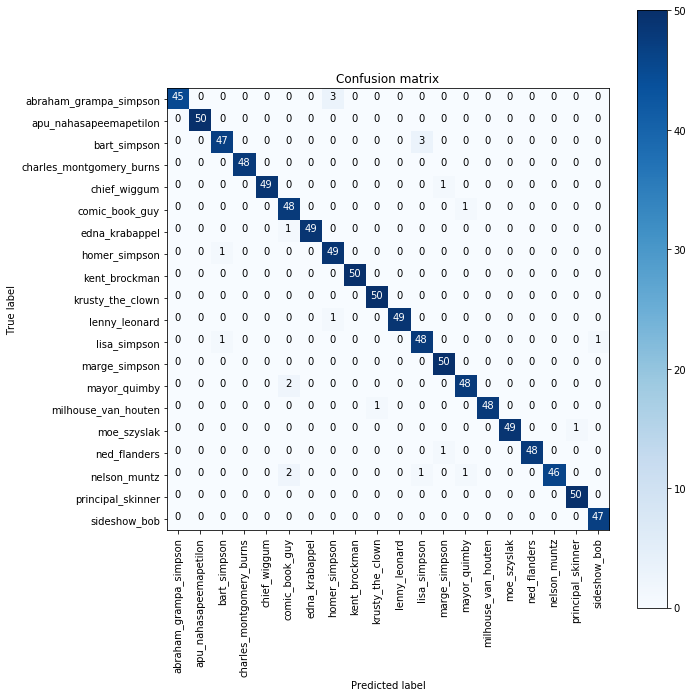

In [17]:

# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert hot vectors prediction results to list of classes
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert hot vectors validation observations to list of classes
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 

Here we can see that our CNN performs very well on all the simpson characters with few errors considering the size of the testing set (990 images).

However, it seems that our CNN has some little troubles recognizing homer simpson , abraham simpson , lisa and bart simpson. . 3 bar simpson are classified as lisa simpson and 3 abraham simpson are classified as homer simpson. For lisa and bart my hypothesis is because they have both spiky haircuts which misleads the model. For abraham and homer "like father like son!".

Nevertheless these erros are very rare , the model is incredibally accurate.

Let's visualize some examples

## 4.2 Some examples

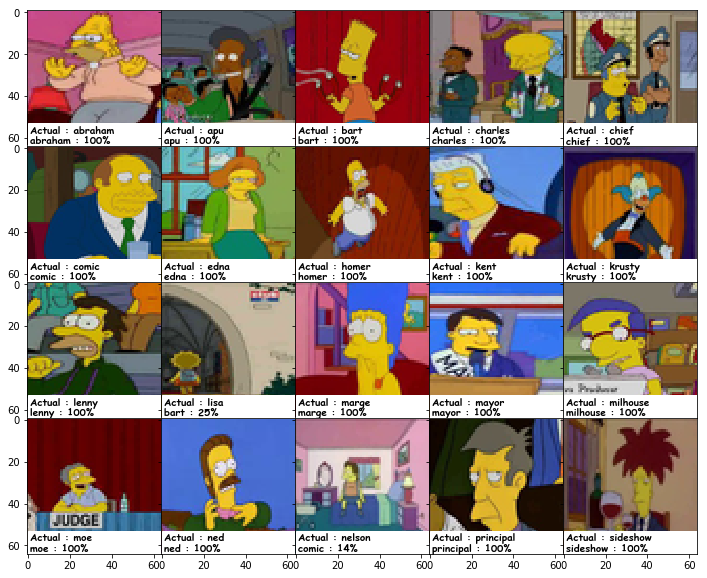

In [18]:
# Display some results 
samples = [pick_up_random_element(elem_type,Y_true) for elem_type in range(20)]
display_samples(samples, X_test, Y_true, Y_pred_classes,Y_pred)

As you can see, the model is accurate to recognize the 20 characters.

So i wanted to predict characters in a video. Since the predictions are faster enough, this is possible (less than 0.1s/image) so we can use our model to predict each frame of a simpson movie.

# 5. Using CNN dynamically
## 5.1 Video demo

In [19]:
def load_icons_characters(dirname,dict_characters):
    dictio = {}
    for character in dict_characters.values():
        character_icon = cv2.imread(dirname+'/'+character+'.png')
        character_icon = scipy.misc.imresize(character_icon,(48,48),interp='lanczos')
        dictio[character] = character_icon
    return dictio

icons = load_icons_characters("I:/yassine/Documents/MOOC/test/face_detection/simpsons_icons",dict_characters)

I create an icons folder where i put icons of the 20 characters and i load them. These icons will be displayed in the scree during the video.

In [20]:
video_capture = cv2.VideoCapture("I:/yassine/Documents/MOOC/test/face_detection/simpson_video.avi")

fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
out = cv2.VideoWriter('I:/yassine/Documents/MOOC/test/face_detection/output.avi', fourcc, 30, (width,height))

In [21]:
while video_capture.isOpened():
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    frame_for_pred = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        
    frame_reshaped = scipy.misc.imresize(frame_for_pred,(64,64,3),interp='lanczos')/255.0
              
    Y_pred = model.predict(np.array([frame_reshaped]))
    
    index_sorted = np.argsort(Y_pred,axis= 1)[0]
    
    top1_pred = Y_pred[0][index_sorted][-1]
    top2_pred = Y_pred[0][index_sorted][-2]
    top3_pred = Y_pred[0][index_sorted][-3]
    
    # I only display confident predictions (>=70%) 
    if top1_pred >= 0.7:
        
        character_name_top1 = dict_characters[index_sorted[-1]]
        character_name_top2 = dict_characters[index_sorted[-2]]
        character_name_top3 = dict_characters[index_sorted[-3]]
    
        Text1 = "%s : %.2f%%"%(character_name_top1.split('_')[0],top1_pred*100)
        Text2 = "%s : %.2f%%"%(character_name_top2.split('_')[0],top2_pred*100)
        Text3 = "%s : %.2f%%"%(character_name_top3.split('_')[0],top3_pred*100)
        
        frame[2:50,2:50] = icons[character_name_top1]
        cv2.putText(frame,Text1,(2,65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        frame[80:128,2:50] = icons[character_name_top2]
        cv2.putText(frame,Text2,(2,143), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        frame[158:206,2:50] = icons[character_name_top3]
        cv2.putText(frame,Text3,(2,221), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    
    # Display the resulting frame
    cv2.imshow('Video', frame)
    
    out.write(frame)
    
    cv2.waitKey(1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

Enjoy the simpson episode :)

In [1]:
import io
import base64
from IPython.display import HTML

video = io.open('output/simpson_CNN_prediction_yassineGhouzam_lowerQ.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

FileNotFoundError: [Errno 2] No such file or directory: 'simpson_CNN_prediction_yassineGhouzam_lowerQ.avi'